In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import random
import matplotlib
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline
# matplotlib.use('TkAgg')
import cv2
import gtsam


In [58]:
class Point_3D:
    def __init__(self):
        """
        Initialize a Point_3D object.

        This class is designed to store and manage 3D points in a dictionary.

        Attributes:
        - points_3D: A dictionary to store 3D points with corresponding keys.
        """
        self.points_3D = {}

    def add_point(self, point, key):
        """
        Add a 3D point to the dictionary.

        Parameters:
        - point: The 3D point to be added.
        - key: The key associated with the 3D point in the dictionary.
        """
        self.points_3D[key] = point

    def get_point(self):
        """
        Get all 3D points stored in the dictionary.

        Returns:
        - Dictionary: The dictionary containing all 3D points with their respective keys.
        """
        return self.points_3D

    def check_point(self, point):
        """
        Check if a given 3D point already exists in the dictionary.

        Parameters:
        - point: The 3D point to be checked.

        Returns:
        - bool: True if the point already exists, False otherwise.
        """
        for point_old in self.points_3D.values():
            if np.array_equal(point, point_old):
                # Return True if the point already exists
                return True
        # Return False if the point is not found in the dictionary
        return False



class Point_2D:
    def __init__(self):
        """
        Initialize a Point_2D object.

        Attributes:
        - points_2D: A dictionary to store 2D points with corresponding keys.
        """
        self.points_2D = {}

    def add_point(self, point, key):
        """
        Add a 2D point to the points_2D dictionary.

        Parameters:
        - point: The 2D point to be added.
        - key: The key associated with the 2D point.
        """
        self.points_2D[key] = point

    def get_point(self):
        """
        Return the dictionary containing all 2D points.

        Returns:
        - points_2D: A dictionary with keys representing points' identifiers and values as 2D points.
        """
        return self.points_2D

    
class SFM:
    def __init__(self):
        self.fundamental_matrix = None
        self.Point_3D = Point_3D()
        self.Point_2D = Point_2D()

    def feature_detector(self,input_image,nfeatures=0,nOctaveLayers=3,contrastThreshold=0.04,edgeThreshold=10,sigma=1.6):
        """
        Apply SIFT feature detector to the input image with customizable parameters.

        Args:
            input_image (numpy.ndarray): The input image.
            nfeatures (int): Number of best features to retain (0 means all features).
            nOctaveLayers (int): Number of layers per octave.
            contrastThreshold (float): Threshold to filter out low-contrast keypoints.
            edgeThreshold (float): Threshold to filter out weak edges.
            sigma (float): The standard deviation of the Gaussian filter applied to the image.

        Returns:
            tuple: A tuple containing keypoints (list) and descriptors (numpy.ndarray).
        """
        
        # Create SIFT detector
        sift = cv2.SIFT_create(nfeatures=nfeatures,nOctaveLayers=nOctaveLayers,contrastThreshold=contrastThreshold,edgeThreshold=edgeThreshold,sigma=sigma)

        # Detect key points and compute descriptors for both images
        key_points, descriptors = sift.detectAndCompute(input_image, None)
        
        return key_points,descriptors
    
    def non_maximum_suppression(self, points, image):
        """
        Performs non-maximum suppression on a list of points based on their responses.

        Parameters:
        - points: List of keypoint objects (e.g., obtained from a feature detector).
        - image: The image on which non-maximum suppression is applied.

        Returns:
        - nms_mask: A list of indices corresponding to the selected keypoints after non-maximum suppression.
        """
        # Get the height and width of the image
        height, width = image.shape[:2]

        # Create a binary mask to keep track of selected keypoints
        binary_mask = np.zeros((height, width), dtype=np.uint8)

        # Extract responses from the list of points
        responses = np.array([point.response for point in points])

        # Sort the responses in descending order and get the corresponding indices
        mask = np.flip(np.argsort(responses))

        # Get the list of points rounded to the nearest integer, sorted based on responses
        point_list = np.rint([point.pt for point in points])[mask].astype(int)

        # Perform non-maximum suppression
        nms_mask = []
        for point, index in zip(point_list, mask):
            # Check if the point is not already selected
            if binary_mask[point[1], point[0]] == 0:
                # Add the index to the final list
                nms_mask.append(index)
                # Mark the selected point on the binary mask
                cv2.circle(binary_mask, tuple(point), 2, 255, -1)

        # Return the list of selected indices after non-maximum suppression
        return nms_mask
    
    def matchers(self,keypoints1,descriptors1,keypoints2,descriptors2,matcher = "FLANN"):
        """
        Apply feature matching on the descriptors using either BFMatcher or FLANN.

        Args:
            descriptors1 (numpy.ndarray): Descriptors from the first set of keypoints.
            descriptors2 (numpy.ndarray): Descriptors from the second set of keypoints.
            matcher (str): The matcher to use, either "BF" for Brute-Force or "FLANN" for FLANN.

        Returns:
            tuple: A tuple containing two NumPy arrays of matched points from descriptors1 and descriptors2.
        """
        
        if matcher == "FLANN":
            # Perform feature matching using FLANN (Fast Library for Approximate Nearest Neighbors) matcher
            flann = cv2.FlannBasedMatcher({'algorithm': 0, 'trees': 5}, {})
            matches = flann.knnMatch(descriptors1, descriptors2, k=2)

            # Apply ratio test to select good matches
            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

            # Extract matched points
            matched_points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
            matched_points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])
            
            return matched_points1,matched_points2
        
        elif matcher == "BF":
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(descriptors1, descriptors2, k=2)
#             matches = sorted(cv2.BFMatcher(cv2.NORM_L1,crosscheck=True).match(des1,des2),key=lambda x:x.distance)
            # Apply ratio test to select good matches
            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

            # Extract matched points
            matched_points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
            matched_points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])
            
            return matched_points1,matched_points2

    def get_fundamental_cv2(self,matched_points1,matched_points2,ransac = False,ransacReprojThreshold=3, maxIters=2000, confidence=0.995):
        """
        Compute the homography matrix using RANSAC based on matched points between two images with customizable RANSAC parameters.

        Args:
            matched_points1 (numpy.ndarray): Array of matched points from the first image.
            matched_points2 (numpy.ndarray): Array of matched points from the second image.
            ransacReprojThreshold (float): Maximum allowable reprojection error.
            maxIters (int): Maximum number of iterations for RANSAC.
            confidence (float): Desired confidence level (probability) that the estimated model is correct.

        Returns:
            numpy.ndarray: The computed homography matrix.
        """
        if len(matched_points1)>=8:
            if ransac == False:
                # Compute the fundamental matrix using 8point
                F, _ = cv2.findFundamentalMat(matched_points1, matched_points2, cv2.FM_8POINT)
            elif ransac == True:
                F, _ = cv2.findFundamentalMat(matched_points1, matched_points2, cv2.RANSAC,ransacReprojThreshold=ransacReprojThreshold, maxIters=maxIters,confidence=confidence)
            
            return F
        else:
            return "Can't comupte fundamental between these images"
        
        
    def normalize_points(self,points):
        """
        Normalize the points
        Args: pts
        Returns: new_ptst,T
        """
        pts = points
        new_ptst = np.empty_like(pts)
        center = (0,0)
        
        # Compute centers and average distances for each set of points            
        for i in range(len(pts)):
            center += pts[i]
        center /= len(pts)

        distance = 0.0
        for i in range(len(pts)):
            new_ptst[i] = pts[i] - center
            distance += np.linalg.norm(new_ptst[i])
        distance /= len(pts)
        # print("distance: ",distance)
        scale = np.sqrt(2)/distance
        for i in range(len(pts)):
            new_ptst[i] *= scale
        
        T = np.array([[scale,0,-center[0]*scale],
                      [0,scale,-center[1]*scale],
                      [0,0,1]])

        return new_ptst,T
    
    def get_fundamental(self, matched_points1, matched_points2):
        """
        Compute the fundamental matrix given two sets of matched points.

        Parameters:
        - matched_points1: List of matched points in the first image.
        - matched_points2: List of matched points in the second image.

        Returns:
        - F: The computed fundamental matrix.
        """

        # Ensure that the input points are in the right format
        matched_points1 = np.array(matched_points1)
        matched_points2 = np.array(matched_points2)

        # Normalize points (optional, but can improve accuracy)
        matched_points1, T1 = self.normalize_points(matched_points1)
        matched_points2, T2 = self.normalize_points(matched_points2)

        # Construct the A matrix for the linear system
        A = []
        for i in range(len(matched_points1)):
            x1, y1 = matched_points1[i]
            x2, y2 = matched_points2[i]
            A.append([x1 * x2, x2 * y1, x2, y2 * x1, y1 * y2, y2, x1, y1, 1])

        A = np.array(A)

        # Solve for the fundamental matrix using the least squares method
        _, _, V = np.linalg.svd(A)
        F = V[-1].reshape(3, 3)

        # Enforce the rank-2 constraint
        U, S, Vt = np.linalg.svd(F)
        S[2] = 0
        F = np.dot(U, np.dot(np.diag(S), Vt))

        # Denormalize the fundamental matrix
        F = np.dot(T2.T, np.dot(F, T1))
        F = F / F[2, 2]

        return F
    
    def is_inlier(self, point1, point2, F, threshold):
        """
        Check if a pair of matched points is an inlier given the fundamental matrix.

        Parameters:
        - point1 (tuple): Coordinates of the first point (x, y).
        - point2 (tuple): Coordinates of the second point (x, y).
        - F (numpy.ndarray): Fundamental matrix.
        - threshold (float): Maximum allowed error for a point pair to be considered an inlier.

        Returns:
        - bool: True if the point pair is an inlier, False otherwise.
        """
        # Convert 2D points to homogeneous coordinates
        point1 = (point1[0], point1[1], 1)
        point2 = (point2[0], point2[1], 1)

        # Calculate epipolar lines
        line1 = np.dot(F, point1)
        line2 = np.dot(F.T, point2)

        # Calculate the geometric error for the point pair
        error = (
            np.abs(np.dot(point2, line1)) / np.sqrt(line1[0] ** 2 + line1[1] ** 2) +
            np.abs(np.dot(point1, line2)) / np.sqrt(line2[0] ** 2 + line2[1] ** 2)
        )

        # Check if the error is below the specified threshold
        return error < threshold
    
    def get_fundamental_ransac(self, matched_points1, matched_points2, num_iterations=2000, threshold=0.1):
        """
        Perform RANSAC to robustly estimate the fundamental matrix between two sets of matched points.

        Parameters:
        - matched_points1: Array of 2D points in the first image.
        - matched_points2: Array of corresponding 2D points in the second image.
        - num_iterations: Number of RANSAC iterations.
        - threshold: Threshold for considering a point as an inlier.

        Returns:
        - best_fundamental: The estimated fundamental matrix with the highest number of inliers.
        """

        best_fundamental = None
        best_inliers = []
        inlier_threshold = threshold

        for _ in range(num_iterations):
            # Randomly sample 8 correspondences
            sampled_indices = random.sample(range(len(matched_points1)), 8)
            sampled_points1 = matched_points1[sampled_indices]
            sampled_points2 = matched_points2[sampled_indices]

            # Compute the fundamental matrix using the sampled points
            F = self.get_fundamental(sampled_points1, sampled_points2)

            # Count inliers
            inliers = []
            for i in range(len(matched_points1)):
                if self.is_inlier(matched_points1[i], matched_points2[i], F, inlier_threshold):
                    inliers.append(i)

            # Keep the best fundamental matrix if it has more inliers
            if len(inliers) > len(best_inliers):
                best_fundamental = F
                best_inliers = inliers

        # Refit the fundamental matrix using all inliers
        best_inlier_points1 = matched_points1[best_inliers]
        best_inlier_points2 = matched_points2[best_inliers]
        best_fundamental = self.get_fundamental(best_inlier_points1, best_inlier_points2)

        return best_fundamental

    def decompose_essential_matrix(self,E,matched_points1,matched_points2,K):
        """
        Decompose the essential matrix into possible camera matrices.

        Parameters:
        - E: Essential matrix.

        Returns:
        - Best possible camera rotation and translation matrices .
        """
        _, R, T, mask = cv2.recoverPose(E, matched_points1, matched_points2, K)
        return R, T

    
    def compute_fundamental(self,image1,image2,Method = "svd_ran"):
        """
        Compute the fundamental matrix between two images using feature detection and matching.

        Args:
            image1 (numpy.ndarray): The first input image.
            image2 (numpy.ndarray): The second input image.
            Method (str): The method to compute the essential matrix. Options: "svd_ran" (default), "svd", "cv2", "cv2_ran".

        Returns:
            numpy.ndarray: The computed homography matrix.
        """
        keypoints1,descriptors1 = self.feature_detector(image1,None)
        keypoints2,descriptors2 = self.feature_detector(image2,None)
        
        matched_points1,matched_points2 = self.matchers(keypoints1,descriptors1,keypoints2,descriptors2,matcher="BF")
        
        if Method == "svd":
            F = self.get_fundamental(matched_points1,matched_points2)
            
        elif Method == "cv2":
            F = self.get_fundamental_cv2(matched_points1,matched_points2)
            
        elif Method == "cv2_ran":
            F = self.get_fundamental_cv2(matched_points1,matched_points2,ransac=True)
            
        elif Method == "svd_ran":
            F = self.get_fundamental_ransac(matched_points1,matched_points2)
        
        return F
    
    def get_essential(self, matched_points1, matched_points2, K, prob=0.999, threshold=1.0):
        """
        Computes the essential matrix E using RANSAC for robustness.

        Parameters:
        - matched_points1: Numpy array of matched points in image 1.
        - matched_points2: Numpy array of matched points in image 2.
        - K: Camera intrinsic matrix.
        - prob: Probability that the algorithm produces a useful result.
        - threshold: RANSAC threshold to determine inliers.

        Returns:
        - E: The essential matrix.
        - matched_points1: Refined matched points in image 1.
        - matched_points2: Refined matched points in image 2.
        """
        # Find the essential matrix E using RANSAC for robustness
        E, mask = cv2.findEssentialMat(matched_points1, matched_points2, K, cv2.RANSAC, prob=prob, threshold=threshold)

        # Refine the matched 2D points using the inlier mask
        matched_points1 = matched_points1[mask.ravel() == 1]
        matched_points2 = matched_points2[mask.ravel() == 1]

        # Return the essential matrix and refined matched points
        return E, matched_points1, matched_points2
    
    def compute_essential(self, image1, image2, K, Method="cv2"):
        """
        Compute the essential matrix between two images using camera matrix, feature detection, and matching.
    
        Args:
            image1 (numpy.ndarray): The first input image.
            image2 (numpy.ndarray): The second input image.
            K (numpy.ndarray): The camera matrix.
            Method (str): The method to compute the essential matrix. Options: "cv2" (default), "svd", "svd_ran".
    
        Returns:
            numpy.ndarray: The computed essential matrix.
        """
        # Step 1: Feature detection and extraction
        keypoints1, descriptors1 = self.feature_detector(image1)
        keypoints2, descriptors2 = self.feature_detector(image2)
    
        # Step 2: Feature matching
        matched_points1, matched_points2 = self.matchers(keypoints1, descriptors1, keypoints2, descriptors2, matcher="FLANN")
    
        # Step 3: Compute essential matrix based on the specified method
        if Method == "svd":
            # Use Singular Value Decomposition (SVD) method
            F = self.compute_fundamental(image1, image2, "svd")
            E = np.matmul(np.matmul(np.transpose(K), F), K)
    
        elif Method == "svd_ran":
            # Use SVD method with random sample consensus (RANSAC)
            F = self.compute_fundamental(image1, image2, "svd_ran")
            E = np.matmul(np.matmul(np.transpose(K), F), K)
    
        elif Method == "cv2":
            # Use OpenCV's built-in function to compute essential matrix
            E, _, _ = self.get_essential(matched_points1, matched_points2,K)
    
        # Return the computed essential matrix
        return E
    
    
    def draw_lines(self, img, lines, points):
        """
        This method draws lines on an image given the lines and corresponding points.
        
        Parameters:
        - img (numpy.ndarray): The input image.
        - lines (numpy.ndarray): The lines to draw on the image.
        - points (numpy.ndarray): The points corresponding to the lines.
        
        Returns:
        - img (numpy.ndarray): The image with lines drawn on it.
        """
        img = img.copy()
        for r, pt in zip(lines, points):
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = map(int, [0, -r[2] / r[1]])
            x1, y1 = map(int, [img.shape[1], -(r[2] + r[0] * img.shape[1]) / r[1]])

            # Convert pt to a tuple directly
            pt_tuple = tuple(map(int, pt))

            img = cv2.line(img, (x0, y0), (x1, y1), color, 2)
            img = cv2.circle(img, pt_tuple, 5, color, -1)
        return img

    
    def plot_epipolar_lines(self, image1, image2, Method="cv2"):
        """
        This method plots the epipolar lines on two images given the methord to calculate fundamental matrix.
        
        Parameters:
        - image1 (numpy.ndarray): The first input image.
        - image2 (numpy.ndarray): The second input image.
        
        Returns:
        - None
        """
        # Step 1: Feature detection and extraction
        keypoints1, descriptors1 = self.feature_detector(image1)
        keypoints2, descriptors2 = self.feature_detector(image2)
        
        # Step 2: Feature matching
        matched_points1, matched_points2 = self.matchers(keypoints1, descriptors1, keypoints2, descriptors2, matcher="FLANN")
        
        # Step 3: Compute fundamental matrix based on the specified method
        if Method == "svd":
            # Use Singular Value Decomposition (SVD) method
            F = self.compute_fundamental(image1, image2, "svd")
    
        elif Method == "svd_ran":
            # Use SVD method with random sample consensus (RANSAC)
            F = self.compute_fundamental(image1, image2, "svd_ran")
 
    
        elif Method == "cv2":
            # Use OpenCV's built-in function to compute essential matrix
            F = self.compute_fundamental(image1, image2, "cv2")
        
        elif Method == "cv2_ran":
            # Use OpenCV's built-in function to compute essential matrix
            F = self.compute_fundamental(image1, image2, "cv2_ran")
            
        # Step 4: Draw epipolar lines
        lines1 = cv2.computeCorrespondEpilines(matched_points2, 2, F)
        lines1 = lines1.reshape(-1, 3)
        lines2 = cv2.computeCorrespondEpilines(matched_points1, 1, F)
        lines2 = lines2.reshape(-1, 3)

        

        # Step 5: Draw epipolar lines on both images
        image1_lines = self.draw_lines(image1, lines1, matched_points1)
        image2_lines = self.draw_lines(image2, lines2, matched_points2)

        # Step 6: Plot the results
        plt.figure(figsize=(12, 6))
        plt.subplot(121), plt.imshow(cv2.cvtColor(image1_lines, cv2.COLOR_BGR2RGB)), plt.title('Image 1 with Epipolar Lines')
        plt.subplot(122), plt.imshow(cv2.cvtColor(image2_lines, cv2.COLOR_BGR2RGB)), plt.title('Image 2 with Epipolar Lines')
        plt.show()
            
        

    def find_key_by_value(self, dictionary, target_value):
        """
        This method searches for a key in a dictionary based on a given target value.
    
        Parameters:
        - dictionary (dict): The dictionary to search through.
        - target_value (any): The value to find in the dictionary.

        Returns:
        - key(any): The key corresponding to the target value if found, otherwise None.
        """
        # Iterate through key-value pairs in the dictionary
        for key, value in dictionary.items():
            # Check if the values (converted to lists) are equal
            if list(value) == list(target_value):
                # Return the key if a match is found
                return key
        
        # Return None if the target value is not found in the dictionary
        return None


    
    def get_transform(self, R, T):
        """
        Get a 4x4 transformation matrix.

        Parameters:
        - R (numpy.ndarray): 3x3 rotation matrix.
        - T (numpy.ndarray): 1D or 2D translation vector.

        Returns:
        - numpy.ndarray: 4x4 transformation matrix combining rotation and translation.
        """
        # Create a 4x4 identity matrix of type float64
        Transform = np.eye(4, dtype=np.float64)

        # Assign the 3x3 rotation matrix to the upper-left 3x3 submatrix of the transformation matrix
        Transform[:3, :3] = R

        # Assign the translation vector to the first three elements of the fourth column of the transformation matrix
        Transform[:3, 3] = T if T.ndim == 1 else T.ravel()

        # Return the resulting 4x4 transformation matrix
        return Transform
        
    def get_projection(self, T, K):
        """
        Computes the projection matrix based on the camera transformation matrix (T) and the camera intrinsic matrix (K).

        Parameters:
        - T (numpy.ndarray): Camera transformation matrix.
        - K (numpy.ndarray): Camera intrinsic matrix.

        Returns:
        - numpy.ndarray: Projection matrix.
        """

        # Use numpy's matrix multiplication (@) to calculate the product of K and the inverse of the first 3 rows/columns of T
        # This operation represents the projection matrix in computer vision
        projection_matrix = K @ np.linalg.inv(T)[:3, :]

        # Return the computed projection matrix
        return projection_matrix
        
    def triangulate(self, P1, P2, mp1, mp2):
        """
        Triangulates 3D points from corresponding 2D points in two images.

        Parameters:
        - P1, P2: Projection matrices for the two cameras.
        - mp1, mp2: Corresponding 2D points in image coordinates.

        Returns:
        - points_3d: Triangulated 3D points.
        - mp1: Filtered 2D points for camera 1.
        - mp2: Filtered 2D points for camera 2.
        """
        # Get the triangulated points
        points_4d = cv2.triangulatePoints(P1, P2, mp1.T, mp2.T)
        
        # Convert to 3D points
        points_3d = points_4d[:3, :] / points_4d[3, :]
        
        # Remove points that are behind the camera
        mask_positive_z = points_3d[2, :] > 0
        points_3d = points_3d[:, mask_positive_z]
        mp1 = mp1[mask_positive_z]
        mp2 = mp2[mask_positive_z]

        # Additional filtering: Remove points too far away (e.g., depth < 1800)
        mask_depth_limit = points_3d[2, :] < 1800
        points_3d = points_3d[:, mask_depth_limit]
        mp1 = mp1[mask_depth_limit]
        mp2 = mp2[mask_depth_limit]
        
        return points_3d.T, mp1, mp2

    
    def compute_points_and_poses_essential(self, image1, image2, K):
        """
        Computes 3D points and camera poses using the essential matrix approach.
    
        Args:
        - image1: First input image.
        - image2: Second input image.
        - K: Camera intrinsic matrix.
    
        Returns:
        - points3d: 3D points reconstructed from the images.
        - camera1_pose: Pose matrix for the first camera (identity matrix).
        - camera2_pose: Pose matrix for the second camera.
        - mp1: Matched keypoints in the first image.
        - mp2: Matched keypoints in the second image.
        """
    
        # Extract keypoints and descriptors from the first image
        kp1, des1 = self.feature_detector(image1)
    
        # Apply non-maximum suppression to keypoints in the first image
        nms_mask = self.non_maximum_suppression(kp1, image1)
        kp1 = np.array(kp1)[nms_mask]
        des1 = np.array(des1)[nms_mask]
    
        # Extract keypoints and descriptors from the second image
        kp2, des2 = self.feature_detector(image2)
    
        # Apply non-maximum suppression to keypoints in the second image
        nms_mask = self.non_maximum_suppression(kp2, image2)
        kp2 = np.array(kp2)[nms_mask]
        des2 = np.array(des2)[nms_mask]
    
        # Match keypoints between the two images
        mp1, mp2 = self.matchers(kp1, des1, kp2, des2)
    
        # Compute the essential matrix and refined matched keypoints
        E, mp1, mp2 = self.get_essential(mp1, mp2, K)
    
        # Decompose the essential matrix to obtain rotation and translation
        R, T = self.decompose_essential_matrix(E, mp1, mp2, K)
    
        # Get the transformation matrix from the second camera to the first
        T_2_1 = self.get_transform(R, T)
    
        # Compute camera poses
        camera1_pose = np.eye(4)
        camera2_pose = np.linalg.inv(T_2_1)
    
        # Get projection matrices for both cameras
        P1 = self.get_projection(camera1_pose, K)
        P2 = self.get_projection(camera2_pose, K)
    
        # Triangulate 3D points using the projection matrices and matched keypoints
        points3d, mp1, mp2 = self.triangulate(P1, P2, mp1, mp2)
    
        # Return the computed 3D points, camera poses, and matched keypoints
        return points3d, camera1_pose, camera2_pose, mp1, mp2
        
            
    def compute_pose_pnp(self, points3d, points2d, K):
        """
        Compute the camera pose using Perspective-n-Point (PnP) algorithm.

        Parameters:
        - points3d: 3D points in the world coordinate system
        - points2d: Corresponding 2D points in the image plane
        - K: Camera intrinsic matrix

        Returns:
        - T_c_w: Transformation matrix representing the camera pose in the world coordinate system
        """
        # Use OpenCV's solvePnP to estimate the camera pose
        success, rvec, t = cv2.solvePnP(points3d, points2d, K, None)

        # If solvePnP is successful, convert rotation vector to rotation matrix
        if success:
            R, _ = cv2.Rodrigues(rvec)

        # Compute the transformation matrix representing the camera pose
        T_c_w = self.get_transform(R, t)

        return T_c_w

    
    def get_2d_3d_corres(self, mp3, mp2, mp4, points_2D, points_3D):
        """
        Given matched points in 2D (mp3), 2D (mp2), and corresponding values (mp4),
        along with dictionaries containing 2D and 3D points, this function returns
        corresponding 3D points and values.

        Parameters:
        - mp3 (list): List of points in 2D space.
        - mp2 (list): List of points in 2D space for comparison.
        - mp4 (list): Corresponding values for matched points.
        - points_2D (dict): Dictionary containing 2D points as keys and their values.
        - points_3D (dict): Dictionary containing 3D points as keys and their values.

        Returns:
        - mp3d (list): List of corresponding 3D points.
        - nmp4 (list): Corresponding values for matched 3D points.
        """

        # Initialize lists to store corresponding 3D points and values
        mp3d = []
        nmp4 = []

        # Iterate through each point in mp3
        for l, j in enumerate(mp3):
            # Check if the point in mp3 is also in mp2
            for k in mp2:
                if np.array_equal(j, k):
                    # Find the key in points_2D corresponding to the matched point
                    key = self.find_key_by_value(points_2D, j)

                    # Extract the 3D point using the key and append to mp3d
                    mp3d.append(points_3D[key.split(",")[1]])

                    # Append the corresponding value from mp4 to nmp4
                    nmp4.append(mp4[l])

        # Return the lists of corresponding 3D points and values
        return mp3d, nmp4
        
    
    def plot_camera(self, R, t, ax, scale=0.5, depth=0.5, faceColor='grey'):
        """
        Plots a camera in a 3D plot.

        Parameters:
        - R (3x3 numpy array): Rotation matrix representing camera orientation.
        - t (3x1 numpy array): Translation vector representing camera position.
        - ax (mpl_toolkits.mplot3d.Axes3D): 3D axis object for plotting.
        - scale (float): Scaling factor for camera size.
        - depth (float): Depth of the camera pyramid.
        - faceColor (str): Face color of the camera pyramid.

        Returns:
        None
        """
        # Calculate camera center in world coordinate system
        C = -t

        # Generating camera coordinate axes
        axes = np.zeros((3, 6))
        axes[0, 1], axes[1, 3], axes[2, 5] = 1, 1, 1

        # Transforming axes to world coordinate system
        axes = R.T.dot(axes) + C[:, np.newaxis]

        # Plotting camera axes
        ax.plot3D(xs=axes[0, :2], ys=axes[1, :2], zs=axes[2, :2], c='r')
        ax.plot3D(xs=axes[0, 2:4], ys=axes[1, 2:4], zs=axes[2, 2:4], c='g')
        ax.plot3D(xs=axes[0, 4:], ys=axes[1, 4:], zs=axes[2, 4:], c='b')

        # Generating 5 corners of the camera pyramid
        pt1 = np.array([[0, 0, 0]]).T  # camera center
        pt2 = np.array([[scale, -scale, depth]]).T  # upper right
        pt3 = np.array([[scale, scale, depth]]).T  # lower right
        pt4 = np.array([[-scale, -scale, depth]]).T  # upper left
        pt5 = np.array([[-scale, scale, depth]]).T  # lower left
        pts = np.concatenate((pt1, pt2, pt3, pt4, pt5), axis=-1)

        # Transforming points to world-coordinate system
        pts = R.T.dot(pts) + C[:, np.newaxis]

        # Plotting camera points
        ax.scatter3D(xs=pts[0, :], ys=pts[1, :], zs=pts[2, :], c='k')

        # Generating a list of vertices to be connected in a polygon
        verts = [
            [pts[:, 0], pts[:, 1], pts[:, 2]],
            [pts[:, 0], pts[:, 2], pts[:, -1]],
            [pts[:, 0], pts[:, -1], pts[:, -2]],
            [pts[:, 0], pts[:, -2], pts[:, 1]]
        ]

        # Generating a polygon
        ax.add_collection3d(Poly3DCollection(verts, facecolors=faceColor, linewidths=1, edgecolors='k', alpha=0.25))
        
    
    def plot_SFM(self, points_3d, camera_pose, plot_points=True, plot_cameras=True):
        """
        Plot the Structure from Motion (SFM) results.

        Parameters:
        - points_3d: Dictionary containing 3D points with keys.
        - camera_pose: Dictionary containing camera poses with keys.
        - plot_points: Boolean, whether to plot 3D points (default=True).
        - plot_cameras: Boolean, whether to plot camera poses (default=True).
        """
        # Extract 3D points from the dictionary values
        points_3d = list(points_3d.values())

        # Extract rotation matrices (R) and translation vectors (T) from camera poses
        R = [pose[:3, :3] for pose in camera_pose.values()]
        T = [pose[:3, 3] for pose in camera_pose.values()]

        # Create a 3D plot
        fig = plt.figure(figsize=(13.0, 11.0))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_aspect('auto')

        # Extract X, Y, and Z coordinates from the 3D points
        X = [point[0] for point in points_3d]
        Y = [point[1] for point in points_3d]
        Z = [point[2] for point in points_3d]

        # Plot 3D points if specified
        if plot_points:
            ax.scatter(X, Y, Z, c='b', marker='o', label='3D Points')

        # Plot cameras if specified
        if plot_cameras:
            for i in range(len(R)):
                self.plot_camera(R[i], T[i], ax)

            # Set axis labels and view orientation
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('depth')
            ax.view_init(azim=-80, elev=110)

        # Show the plot
        plt.legend()
        plt.show()
        
        
    
    def SFM(self,path,K):
        """
        Pass the images in the provided path to a structure from motion pipeline

        Parameters:
        - path (str): Path of the dataset.
        - K (3x3 numpy array): Calibration matrix.

        Returns:
        Tuple of point3d,point2d, and camera_pose dictionaries after optimization.
        """
        # Dictionary to store camera poses
        camera_pose = {}

        # Get the list of sorted images in the specified path
        image_list = sorted(os.listdir(path))
        N = len(image_list)

        # Read the first two images to initialize the pipeline
        image1 = cv2.imread(os.path.join(path, image_list[0]))
        image2 = cv2.imread(os.path.join(path, image_list[1]))

        # Compute 3D points, camera poses, and correspondences for the first two images
        points3d, camera1_pose, camera2_pose, mpp1, mpp2 = self.compute_points_and_poses_essential(image1, image2, K)

        # Store camera poses for the first two images
        camera_pose["x0"] = camera1_pose
        camera_pose["x1"] = camera2_pose

        # Add 3D points and 2D correspondences to Point_3D and Point_2D instances
        for i, (points, p1, p2) in enumerate(zip(points3d, mpp1, mpp2)):
            self.Point_3D.add_point(points, f"l{i}")
            self.Point_2D.add_point(p1, f"x0,l{i}")
            self.Point_2D.add_point(p2, f"x1,l{i}")
            last_c = i + 1

        # Loop through the remaining images to perform SFM
        for i in range(1, N - 1):
            # Read the current and next images
            image1 = cv2.imread(os.path.join(path, image_list[i]))
            image2 = cv2.imread(os.path.join(path, image_list[i + 1]))

            # Feature detection and matching
            kp1,des1 = self.feature_detector(image1)
            nms_mask = self.non_maximum_suppression(kp1,image1)
            kp1 = np.array(kp1)[nms_mask]
            des1 = np.array(des1)[nms_mask]
            kp2,des2 = self.feature_detector(image2)
            nms_mask = self.non_maximum_suppression(kp2,image2)
            kp2 = np.array(kp2)[nms_mask]
            des2 = np.array(des2)[nms_mask]
            mp3, mp4 = self.matchers(kp1, des1, kp2, des2)

            # Get the essential matrix and correspondences
            E, mp3, mp4 = self.get_essential(mp3, mp4, K)

            # Get 2D-3D correspondences using the essential matrix
            mp3d, nmp4 = self.get_2d_3d_corres(mp3, mpp2, mp4, self.Point_2D.get_point(), self.Point_3D.get_point())

            # Compute the pose using PnP
            T_2_w = self.compute_pose_pnp(np.array(mp3d, dtype=np.float32), np.array(nmp4, dtype=np.float32), K)

            # Invert the pose to get the world-to-camera transformation
            camera_pose[f'x{i + 1}'] = np.linalg.inv(T_2_w)

            # Get the projection matrices for the current and next cameras
            P1 = self.get_projection(camera_pose[f"x{i}"], K)
            P2 = self.get_projection(camera_pose[f"x{i + 1}"], K)

            # Triangulate points between the two cameras
            points3d, mp3, mp4 = self.triangulate(P1, P2, mp3, mp4)

            # Update Point_3D and Point_2D instances with the new points and correspondences
            for m, points in enumerate(points3d):
                if self.Point_3D.check_point(points):
                    key = self.find_key_by_value(self.Point_3D.get_point(), points)
                    self.Point_2D.add_point(mp3[m], f"x{i}," + key)
                    self.Point_2D.add_point(mp4[m], f"x{i+1,}" + key)
                else:
                    self.Point_3D.add_point(points, f"l{last_c}")
                    self.Point_2D.add_point(mp3[m], f"x{i},l{last_c}")
                    self.Point_2D.add_point(mp4[m], f"x{i+1},l{last_c}")
                    last_c += 1

            # Update the list of 2D correspondences for the next iteration
            mpp2 = mp4

        # Return the final 3D points, 2D correspondences, and camera poses
        return self.Point_3D.get_point(), self.Point_2D.get_point(), camera_pose
    
            
        
    def BA(self, point3d, point2d, camera_pose, K):
        """
        Bundle Adjustment using GTSAM library.

        Parameters:
        - point3d: Dictionary containing 3D points.
        - point2d: Dictionary containing 2D image points.
        - camera_pose: Dictionary containing camera poses.
        - K: Calibration matrix.

        Returns:
        Tuple of updated point3d and camera_pose dictionaries after optimization.
        """

        # Create shorthand variables
        L = gtsam.symbol_shorthand.L
        X = gtsam.symbol_shorthand.X

        # Create the camera matrix factor and the calibration matrix key
        K = gtsam.Cal3_S2(K[0, 0], K[1, 1], 0.0, K[0, 2], K[1, 2])

        # Define the camera observation noise model
        measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 10.0)  # one pixel in u and v

        # Create the factor graph
        graph = gtsam.NonlinearFactorGraph()

        # Add a prior on pose x1. This indirectly specifies where the origin is.
        # 0.3 rad std on roll, pitch, yaw and 0.1m on x, y, z
        pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
        factor = gtsam.PriorFactorPose3(X(0), gtsam.Pose3(camera_pose['x0']), pose_noise)
        graph.push_back(factor)

        # Loop over the points
        for key in point2d.keys():
            measurement = point2d[key]
            i = int(key.split(',')[0][1:])
            j = int(key.split(',')[1][1:])
            factor = gtsam.GenericProjectionFactorCal3_S2(measurement, measurement_noise, X(i), L(j), K)
            graph.push_back(factor)

        # Add the prior on the position of the first landmark
        point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 1)
        factor = gtsam.PriorFactorPoint3(L(0), gtsam.Point3(point3d["l0"]), point_noise)
        graph.push_back(factor)

        # Initialize the estimates
        initial_estimate = gtsam.Values()
        for i in range(len(camera_pose)):
            initial_estimate.insert(X(i), gtsam.Pose3(camera_pose[f'x{i}']))

        for key in point3d.keys():
            i = int(key[1:])
            initial_estimate.insert(L(i), gtsam.Point3(point3d[key]))

        # Optimize the graph
        params = gtsam.LevenbergMarquardtParams()
        params.setVerbosityLM("SUMMARY")
        optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
        result = optimizer.optimize()
        print("Final error: ", graph.error(result))

        # Update the camera poses
        for i in range(len(camera_pose)):
            camera_pose[f'x{i}'] = result.atPose3(X(i)).matrix()

        # Update the point cloud
        for j, key in enumerate(point3d.keys()):
            point3d[key] = result.atPoint3(L(j))

        return point3d, camera_pose

        

    

In [59]:
my_sfm = SFM()

# Results of Finding Fundamental Matrix:
## "Finding the fundamental matrix from SVD (F), SVD with RANSAC (F_ran), OpenCV function (F_cv2), and OpenCV function with RANSAC (F_cv2_ran)"

In [9]:
image1 = cv2.imread('/home/rupeshpathak/buddha/buddha_001.png')  
image2 = cv2.imread('/home/rupeshpathak/buddha/buddha_002.png')    
F = my_sfm.compute_fundamental(image1,image2,"svd")
F_cv2 = my_sfm.compute_fundamental(image1,image2,"cv2")
F_cv2_ran = my_sfm.compute_fundamental(image1,image2,"cv2_ran")
F_ran = my_sfm.compute_fundamental(image1,image2,"svd_ran")
print("F = ",F)
print("F_ran = ",F_ran)
print("F_cv2 = ",F_cv2)
print("F_cv2_ran = ",F_cv2_ran)

F =  [[ 8.84833550e-06  1.47207339e-05  4.69022766e-03]
 [-1.56059542e-05  6.63704036e-07  4.64875748e-03]
 [-1.27241657e-02 -5.20900196e-03  1.00000000e+00]]
F_ran =  [[-7.44055270e-07 -1.96180542e-03  1.56954306e+00]
 [ 1.96244383e-03 -2.03046664e-07 -1.48258714e+00]
 [-1.56895016e+00  1.48098777e+00  1.00000000e+00]]
F_cv2 =  [[ 8.84832827e-06  1.47207217e-05  4.69022300e-03]
 [-1.56059405e-05  6.63703341e-07  4.64875364e-03]
 [-1.27241562e-02 -5.20899749e-03  1.00000000e+00]]
F_cv2_ran =  [[ 1.22633193e-06  1.46656977e-03 -2.34950842e+00]
 [-1.46833801e-03  3.07589073e-06  1.15672410e+00]
 [ 2.35078675e+00 -1.16198615e+00  1.00000000e+00]]


# Plotting the results of the fundamental matrix

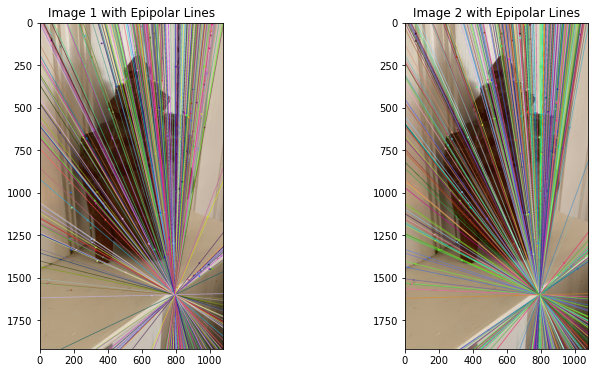

In [60]:
image1 = cv2.imread('/home/rupeshpathak/buddha/buddha_001.png')  
image2 = cv2.imread('/home/rupeshpathak/buddha/buddha_002.png') 
my_sfm.plot_epipolar_lines(image1,image2,Method="cv2_ran")

### We can see that my SVD estimate and OpenCV funtion's fundamental matrix is identical, it's just that the RANSAC values used by OpenCV is different so we can not get identical results after RANSAC implementation.

# Generating the K matrix using the values fx,fy,cx and cy.

In [33]:
fx= 1690
fy= 1690
cx = 540
cy = 960
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]], dtype=np.float32)

# Results of Finding Essential Matrix:
## Finding the Essential matrix from SVD (E), SVD with RANSAC (E_ran), and OpenCV function (E_cv2)


In [10]:
image1 = cv2.imread('/home/rupeshpathak/buddha/buddha_001.png')  
image2 = cv2.imread('/home/rupeshpathak/buddha/buddha_002.png') 
E = my_sfm.compute_essential(image1,image2,K,"svd")
E_ran = my_sfm.compute_essential(image1,image2,K,"svd_ran")
E_cv2 = my_sfm.compute_essential(image1,image2,K,"cv2")
print("E = ", E)
print("E_ran = ", E_ran)
print("E_cv2 = ", E_cv2)

E =  [[ 25.27173103  42.04388802  39.88439436]
 [-44.57216574   1.8956051   -5.30880022]
 [-38.74794907   5.70772184  -1.14321516]]
E_ran =  [[-8.33895965e-01 -2.33616247e+03  7.73337734e+01]
 [ 2.33762353e+03 -3.82451771e-02  4.21653930e+02]
 [-7.71543213e+01 -4.23020070e+02  1.13594578e-01]]
E_cv2 =  [[-2.91580324e-04  3.00620360e-01 -6.39970741e-01]
 [-3.00248273e-01  6.84420495e-05  8.21881367e-03]
 [ 6.40141198e-01 -8.20346427e-03 -3.69449198e-04]]


### The essential matrix generated by OpenCV is using a completely different method than ours, which is to compute the fundamental matrix and then find the essential matrix using E = K.T @ F @ K. It directly tries to minimize the error for the essential matrix, thus generating a better result. However, we can see that my RANSAC implementation is better than just the SVD implementation.


# Passing the dataset to the structure-from-motion pipeline without bundle adjustment.

In [37]:
point3d,point2d,camera_pose = my_sfm.SFM("/home/rupeshpathak/buddha",K)

# Plots Before Bundle Adjustment 

### 1) Generated point cloud with the relative camera poses.

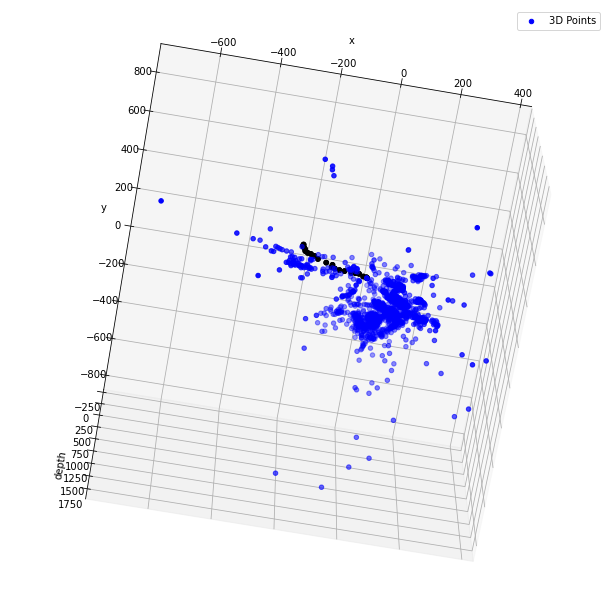

In [39]:
my_sfm.plot_SFM(point3d,camera_pose,plot_cameras=True,plot_points=True)

### 2) Generated relative camera poses.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


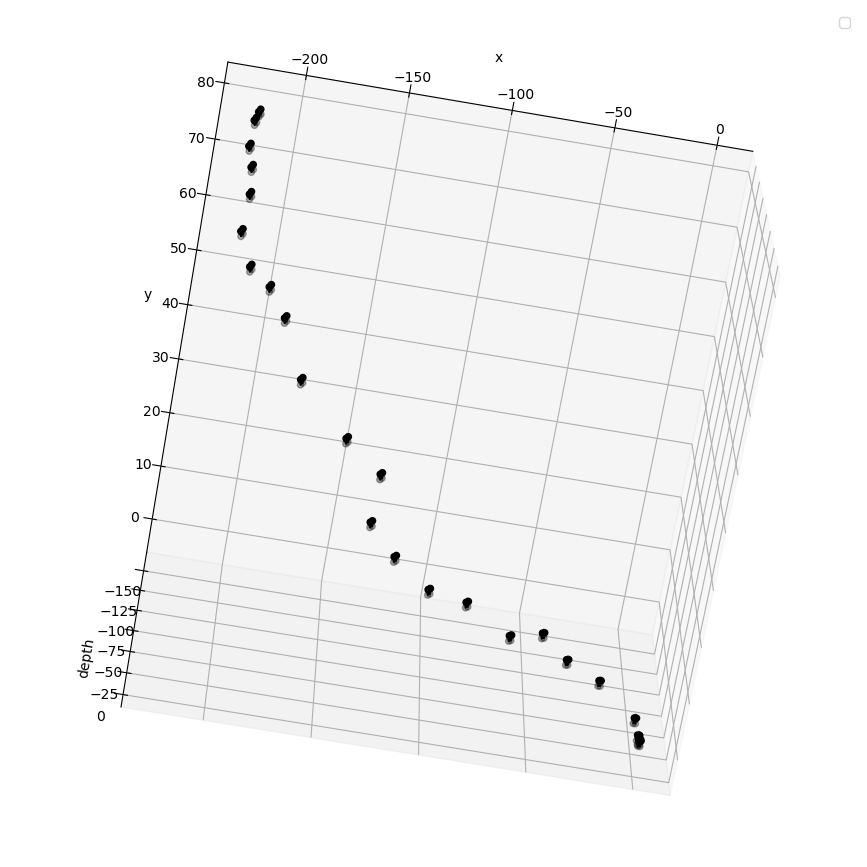

In [17]:
my_sfm.plot_SFM(point3d,camera_pose,plot_cameras=True,plot_points=False)

### 3) Generated point cloud

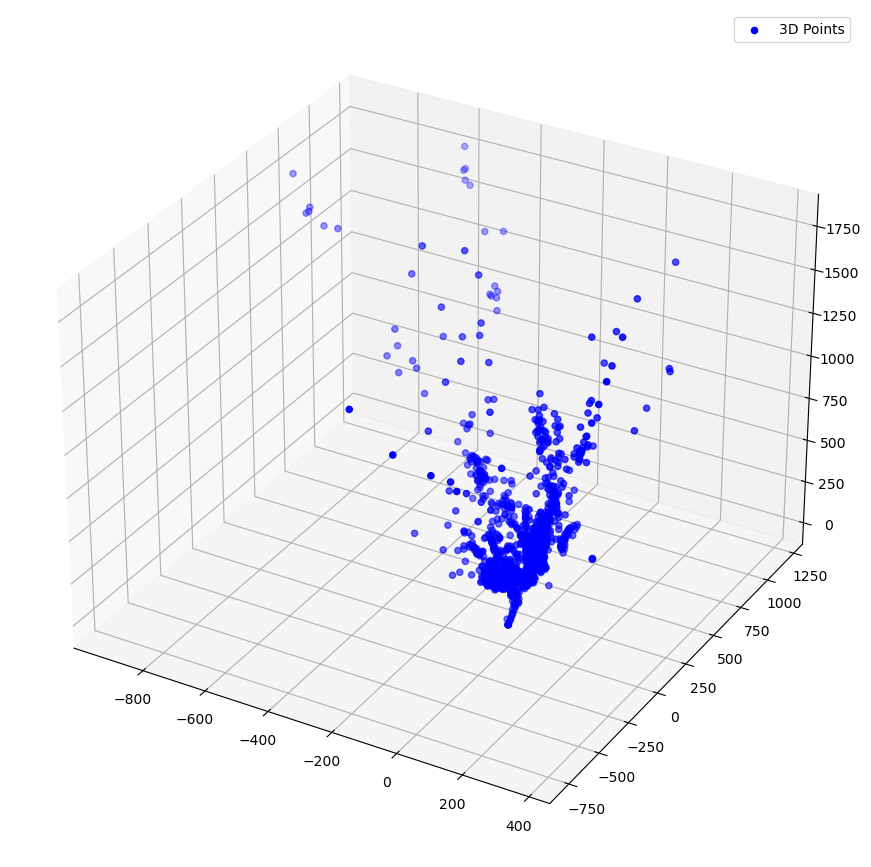

In [18]:
my_sfm.plot_SFM(point3d,camera_pose,plot_cameras=False,plot_points=True)

# Rotated point cloud to visualize the structure better.

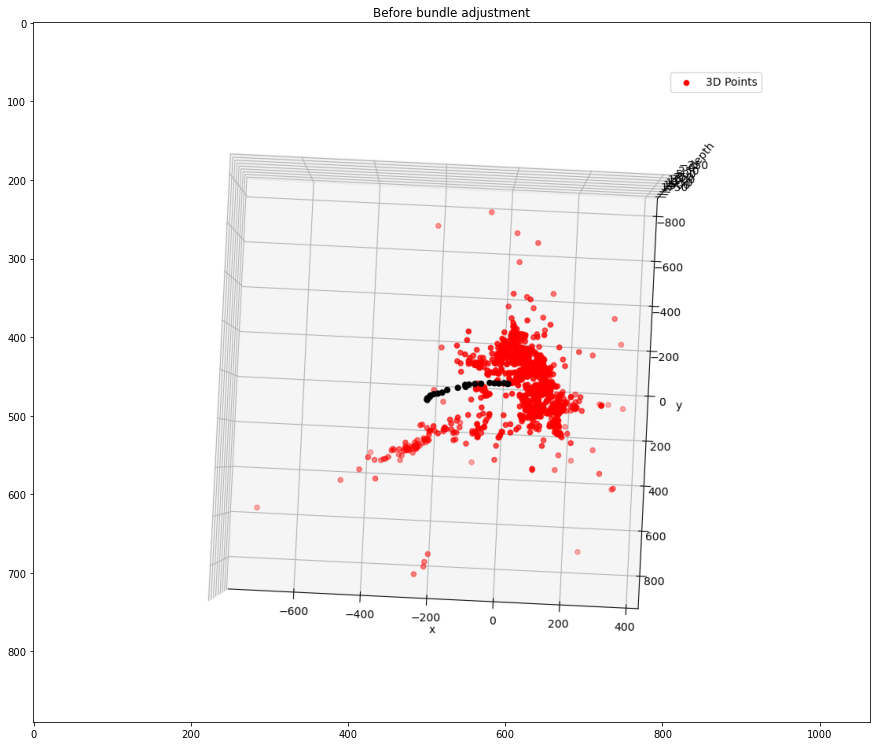

In [51]:
image = cv2.imread('/home/rupeshpathak/buddha/Without bundle adjustment.png')
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.title("Before bundle adjustment")
plt.show()

# During Bundle Adjustment using GTSAM, the initial error and final error are displayed.

In [32]:
point3d_op,camera_pose_op = my_sfm.BA(point3d,point2d,camera_pose,K)

Initial error: 632.527, values: 1729
Final error:  44.24382465856414
iter      cost      cost_change    lambda  success iter_time
   0  4.573640e+05   -4.57e+05    1.00e-05     1    1.40e-02
iter      cost      cost_change    lambda  success iter_time
   0  4.573623e+05   -4.57e+05    1.00e-04     1    1.38e-02
iter      cost      cost_change    lambda  success iter_time
   0  2.289755e+05   -2.28e+05    1.00e-03     1    1.51e-02
iter      cost      cost_change    lambda  success iter_time
   0  1.167043e+05   -1.16e+05    1.00e-02     1    1.38e-02
iter      cost      cost_change    lambda  success iter_time
   0  3.625642e+02    2.70e+02    1.00e-01     1    1.73e-02
   1  2.285356e+05   -2.28e+05    1.00e-02     1    1.63e-02
   1  1.822666e+02    1.80e+02    1.00e-01     1    1.42e-02
   2  2.285126e+05   -2.28e+05    1.00e-02     1    1.36e-02
   2  1.143312e+05   -1.14e+05    1.00e-01     1    1.45e-02
   2  1.428917e+02    3.94e+01    1.00e+00     1    1.35e-02
   3  1.142955e+

# Plots After Bundle Adjustment


### 1) Generated point cloud with the relative camera poses.

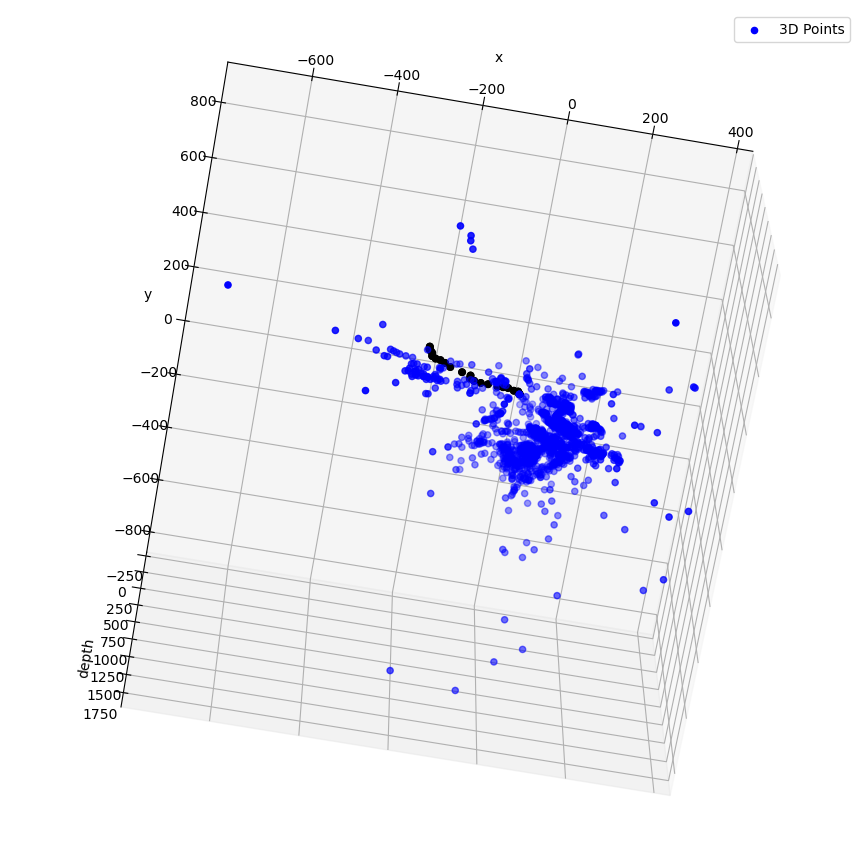

In [26]:
my_sfm.plot_SFM(point3d_op,camera_pose_op,plot_cameras=True,plot_points=True)

### 2) Generated relative camera poses.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


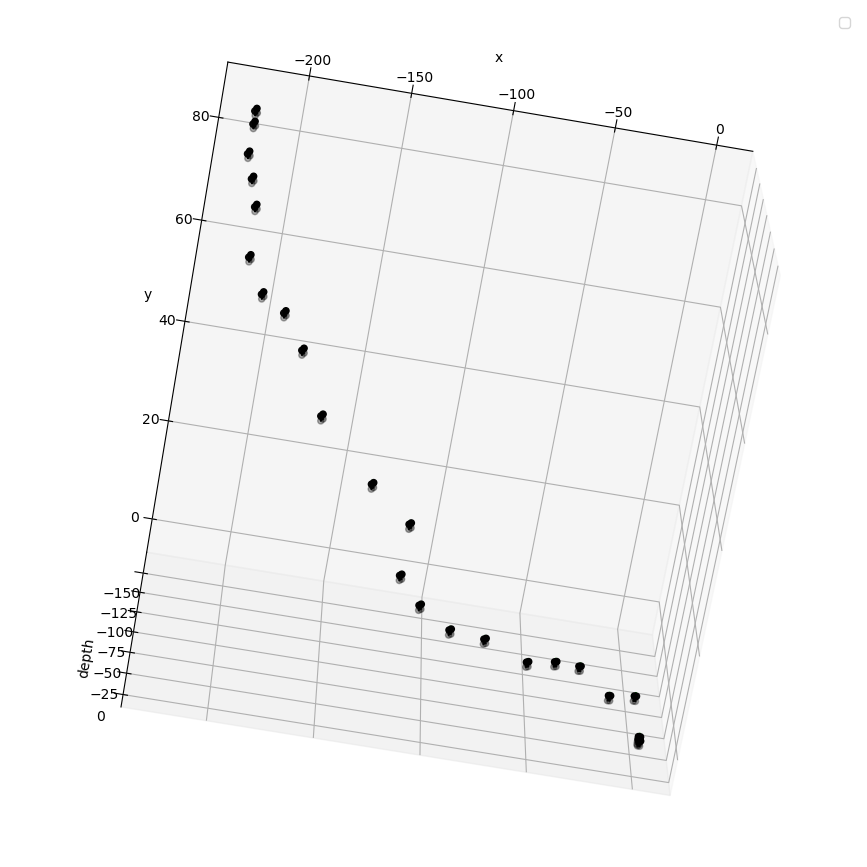

In [27]:
my_sfm.plot_SFM(point3d_op,camera_pose_op,plot_cameras=True,plot_points=False)

### 3) Generated point cloud.

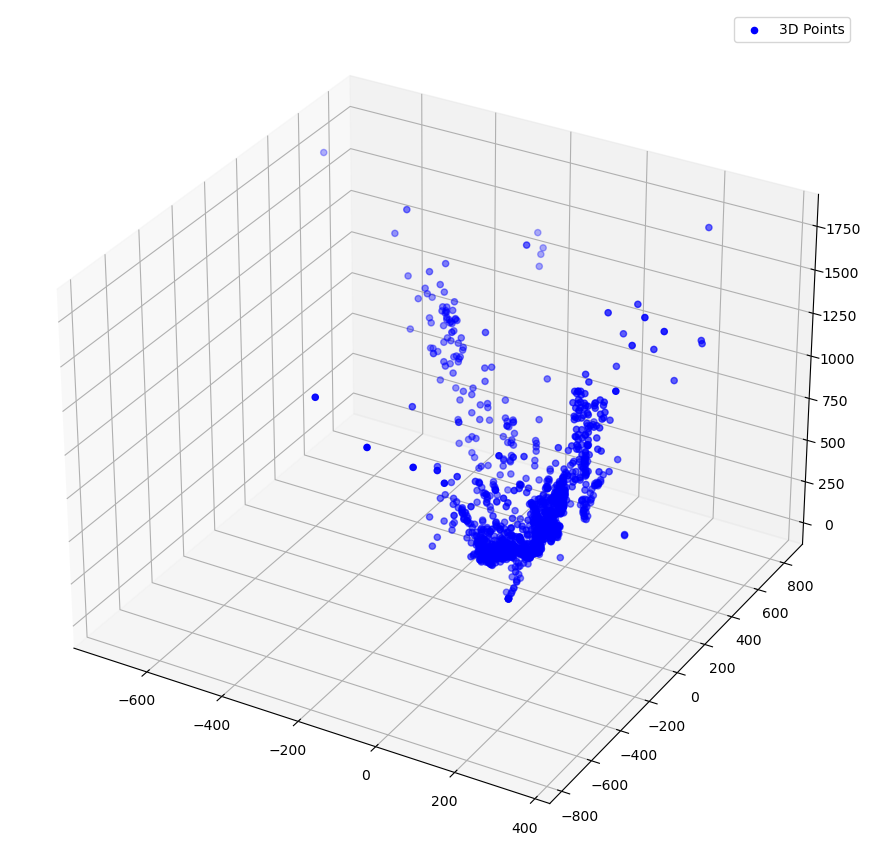

In [28]:
my_sfm.plot_SFM(point3d_op,camera_pose_op,plot_cameras=False,plot_points=True)

# Rotated point cloud to visualize the structure better.

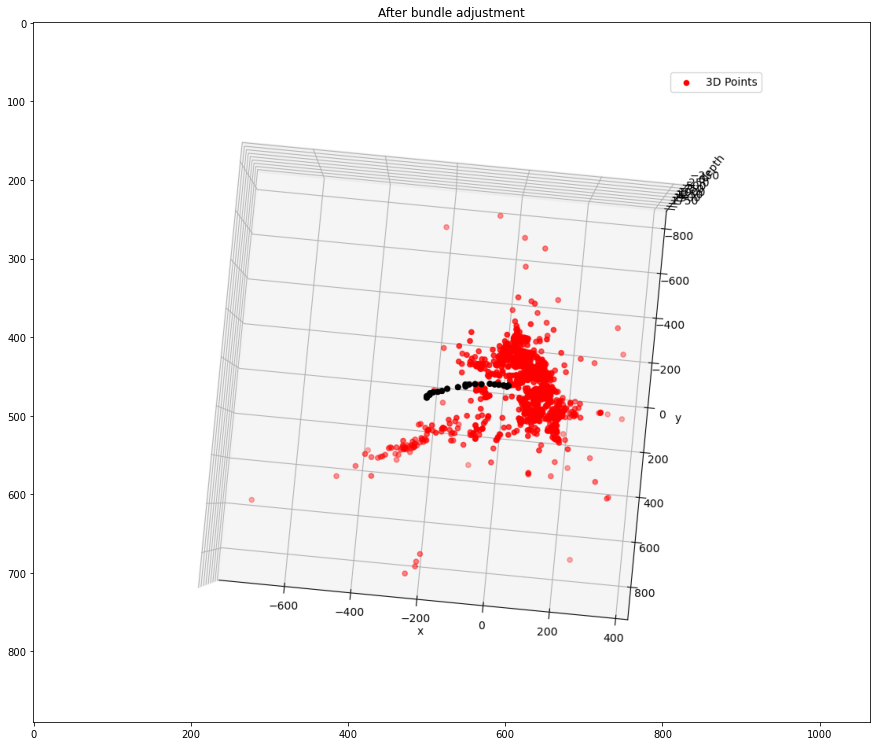

In [50]:
image = cv2.imread('/home/rupeshpathak/buddha/After bundle adjustment.png')
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.title("After bundle adjustment")
plt.show()